In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles

import yaml

In [7]:
predictions_dict = {}

In [8]:
config_filename = 'default.yaml'
config = read_config(config_filename)

In [9]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

  0%|          | 0/15000 [00:00<?, ?it/s]Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_17112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 172                 | 173                 | 174                 | 175                 | 176                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-10-15 00:00:00 | 2020-10-16 00:00:00 | 2020-10-17 00:00:00 | 2020-10-18 00:00:00 | 2020-10-19 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 236513.43           | 238242.43           | 240335.0      

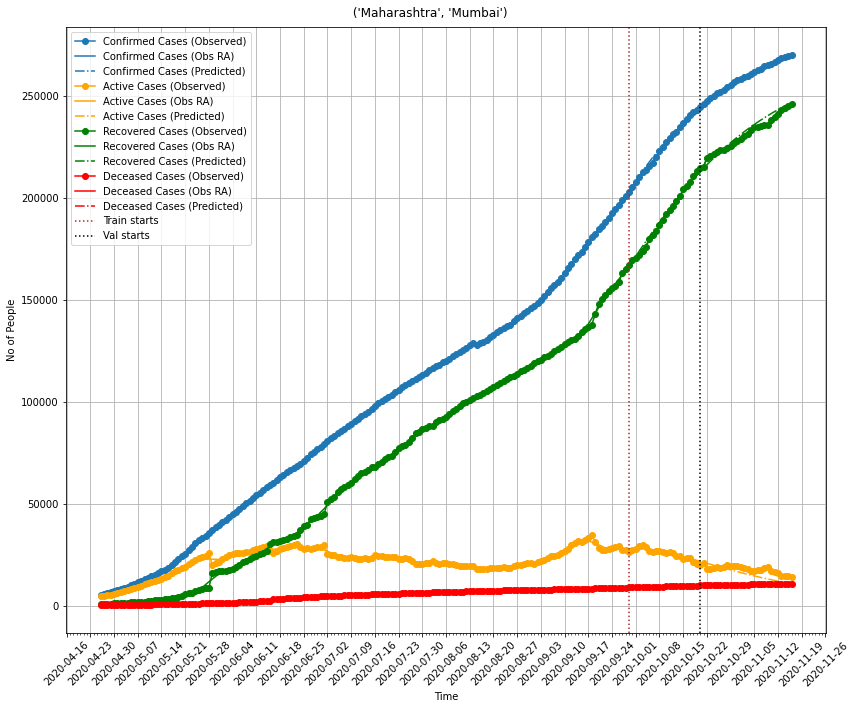

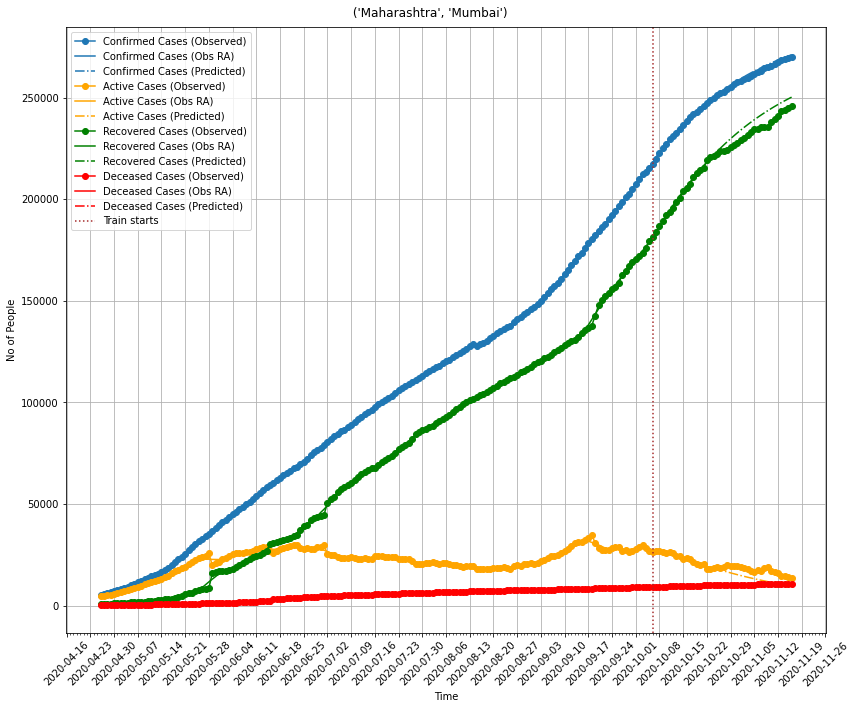

In [6]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

In [8]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.4050225822242689,
 'I_hosp_ratio': 0.2905482676274374,
 'P_fatal': 0.038369705034573286,
 'T_inc': 4.029706459275294,
 'T_inf': 3.6540668582745357,
 'T_recov': 11.18924076494724,
 'T_recov_fatal': 26.76527152031356,
 'lockdown_R0': 0.7560161233951846}

In [9]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.1683418297382109,
 'I_hosp_ratio': 0.37657920402634804,
 'P_fatal': 0.045766470195857625,
 'T_inc': 4.447031219182316,
 'T_inf': 3.432856252922971,
 'T_recov': 9.956230942273665,
 'T_recov_fatal': 35.941130122760924,
 'lockdown_R0': 0.866354071052884}

## Loss Dataframes

### M1 Loss DataFrame

In [10]:
predictions_dict['m1']['df_loss']

,train,val
total,0.416085,1.15138
active,2.76839,4.30145
recovered,0.644986,1.53283
deceased,0.35034,1.19215


### M2 Loss DataFrame

In [11]:
predictions_dict['m2']['df_loss']

,train
total,0.251707
active,2.69323
recovered,0.295816
deceased,0.277478


In [ ]:
from main.seir.forecast import _get_top_k_trials as topk
_,loss = topk(predictions_dict['m2'], k = 1)
loss

## Sensitivity Plot

In [ ]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

0it [00:00, ?it/s]

getting forecasts ..
getting forecasts ..


1500it [00:11, 135.55it/s]
15it [00:00, 139.46it/s]

getting forecasts ..


135it [00:00, 146.50it/s]/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:336: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:358: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
1500it [00:13, 111.38it/s]


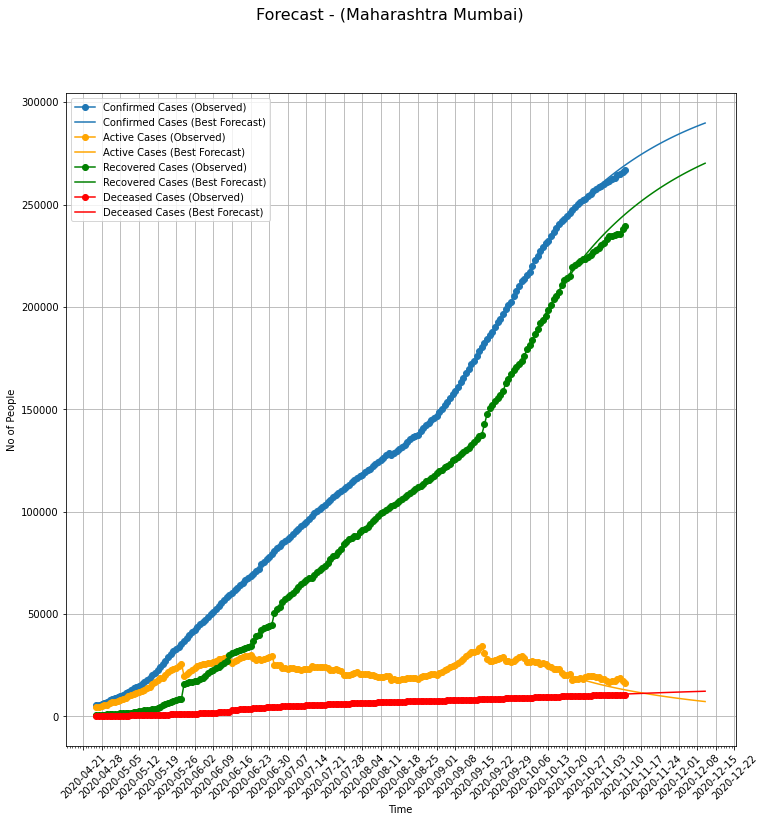

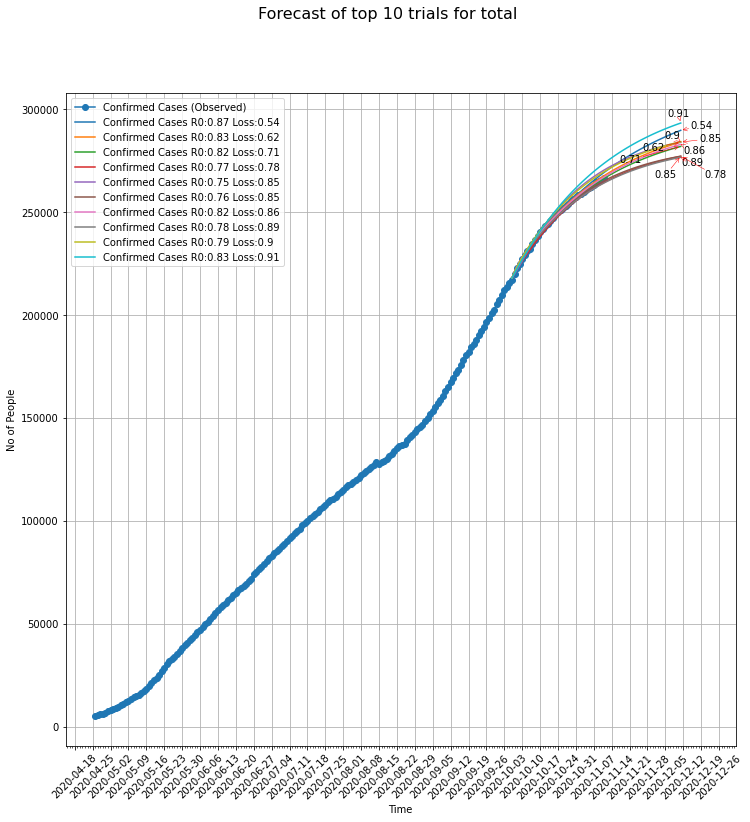

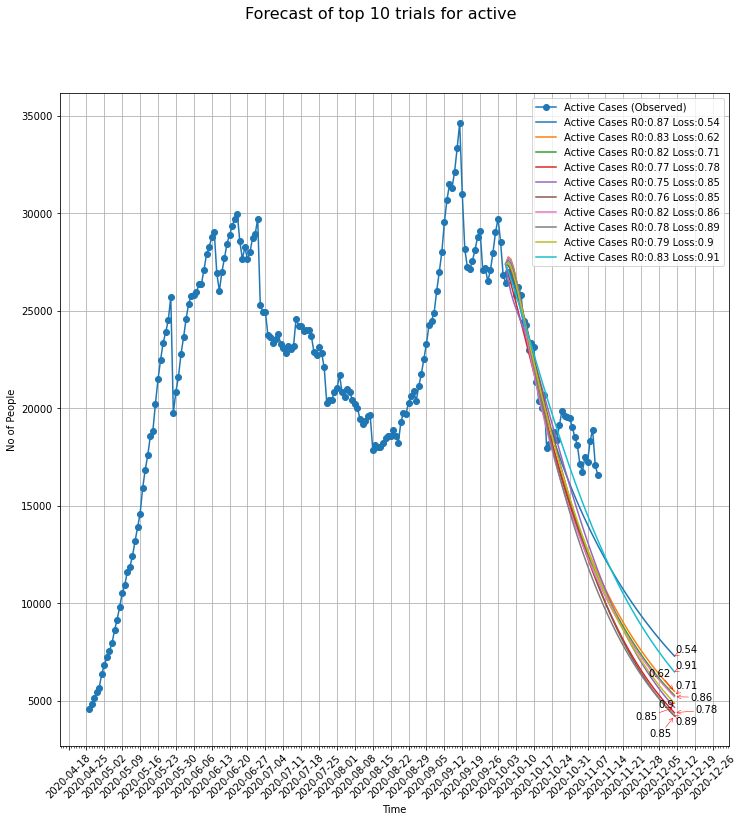

In [12]:
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 (config['fitting']['data']['dataloading_params']['state'], 
                                                                  config['fitting']['data']['dataloading_params']['district']), 
                                                                 error_bars=False)

predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])
                               
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [13]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [00:54<00:00,  1.84trial/s, best loss: 1.7303501726775046]


In [18]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']

predictions_dict['m2']['forecasts']['ensemble_mean'],predictions_dict['m2']['forecasts']['ensemble_mean_loss'] = uncertainty.ensemble_mean_forecast

In [ ]:
#predictions_dict['m2']['beta'] = uncertainty.beta
#predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

In [ ]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
# predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
#                                                                              (config['fitting']['data']['dataloading_params']['state'], 
#                                                                               config['fitting']['data']['dataloading_params']['district']),
#                                                                              fits_to_plot=['ensemble_mean', 50], error_bars=False)

In [ ]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## Create Report

In [ ]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output

In [ ]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

In [ ]:
log_wandb(predictions_dict)

## Create All Trials Output

In [ ]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')